In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import matplotlib as mpl

import warnings
import IPython
import IPython.display
warnings.filterwarnings('ignore')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

# Load Data

In [2]:
df = pd.read_csv("final_data.csv")
df = df.drop(["Unnamed: 0"], axis=1)
df.head()

,data,price,holiday,weekend,Biomass,Fossil Brown coal/Lignite,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,...,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore,temp,dew,humidity,windspeed,cloudcover
0,2021-01-01 00:00:00+01:00,50.87,1,0,0.251895,-0.143810,0.089097,-0.917275,0.910925,1.738799,...,1.605983,-1.045366,-0.017919,-1.373297,-0.764926,-1.081656,-0.811902,1.124154,-2.001679,0.091973
1,2021-01-01 01:00:00+01:00,48.19,1,0,0.202401,-0.146125,0.003747,-1.076303,0.910925,1.738799,...,1.605983,-1.045366,-0.030455,-1.360016,-0.862617,-1.081656,-0.811902,1.124154,-2.001679,0.091973
2,2021-01-01 02:00:00+01:00,44.68,1,0,0.194153,-0.082879,-0.032225,-1.067072,0.912335,1.738799,...,1.605983,-1.045366,-0.097402,-1.468535,-0.950572,-1.081656,-0.811902,1.124154,-2.001679,0.091973
3,2021-01-01 03:00:00+01:00,42.92,1,0,0.147760,0.161970,-0.101831,-1.156591,0.912335,1.738799,...,1.605983,-1.045366,-0.177528,-1.450608,-1.077902,-1.081656,-0.811902,1.124154,-2.001679,0.091973
4,2021-01-01 04:00:00+01:00,40.39,1,0,0.150853,0.187129,-0.154407,-1.216422,0.910220,1.738799,...,1.705195,-1.045366,-0.274511,-1.480265,-1.174635,-1.081656,-0.811902,1.124154,-2.001679,0.091973


In [3]:
date_time = pd.to_datetime(df.pop("data"))

In [4]:
df.head()

,price,holiday,weekend,Biomass,Fossil Brown coal/Lignite,Fossil Gas,Fossil Hard coal,Fossil Oil,Geothermal,Hydro Pumped Storage,...,Other renewable,Solar,Waste,Wind Offshore,Wind Onshore,temp,dew,humidity,windspeed,cloudcover
0,50.87,1,0,0.251895,-0.143810,0.089097,-0.917275,0.910925,1.738799,-0.255558,...,1.605983,-1.045366,-0.017919,-1.373297,-0.764926,-1.081656,-0.811902,1.124154,-2.001679,0.091973
1,48.19,1,0,0.202401,-0.146125,0.003747,-1.076303,0.910925,1.738799,-0.003677,...,1.605983,-1.045366,-0.030455,-1.360016,-0.862617,-1.081656,-0.811902,1.124154,-2.001679,0.091973
2,44.68,1,0,0.194153,-0.082879,-0.032225,-1.067072,0.912335,1.738799,-0.525943,...,1.605983,-1.045366,-0.097402,-1.468535,-0.950572,-1.081656,-0.811902,1.124154,-2.001679,0.091973
3,42.92,1,0,0.147760,0.161970,-0.101831,-1.156591,0.912335,1.738799,-2.299009,...,1.605983,-1.045366,-0.177528,-1.450608,-1.077902,-1.081656,-0.811902,1.124154,-2.001679,0.091973
4,40.39,1,0,0.150853,0.187129,-0.154407,-1.216422,0.910220,1.738799,-2.037045,...,1.705195,-1.045366,-0.274511,-1.480265,-1.174635,-1.081656,-0.811902,1.124154,-2.001679,0.091973


# Split Data

In [21]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [22]:
num_features = df.shape[1]
num_features

24

In [23]:
X_temp = df.drop(['weekend', 'holiday'], axis=1)
X_col = X_temp.columns

# Normalize data

In [24]:
train_mean = train_df.mean()
train_std = train_df.std()

In [25]:
for col in X_col:
    train_df[col] = (train_df[col] - train_mean[col]) / train_std[col]
    val_df[col] = (val_df[col] - train_mean[col]) / train_std[col]
    test_df[col] = (test_df[col] - train_mean[col]) / train_std[col]

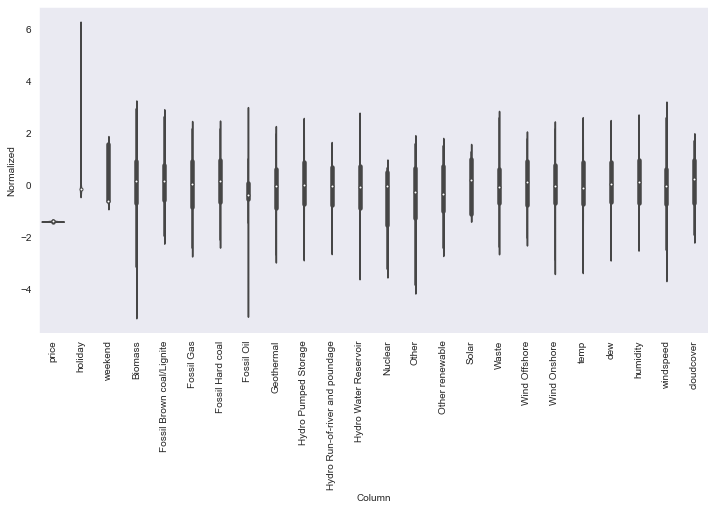

In [27]:
df_std = (train_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(train_df.keys(), rotation=90)

# Data Window

In [28]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])


In [29]:
w2 = WindowGenerator(input_width=4, label_width=1, shift=1,
                     label_columns=['price'])
w2

Total window size: 5
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['price']

In [30]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [31]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 5, 24)
Inputs shape: (3, 4, 24)
Labels shape: (3, 1, 1)


In [32]:
w2.example = example_inputs, example_labels

In [33]:
def plot(self, model=None, plot_col='price', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

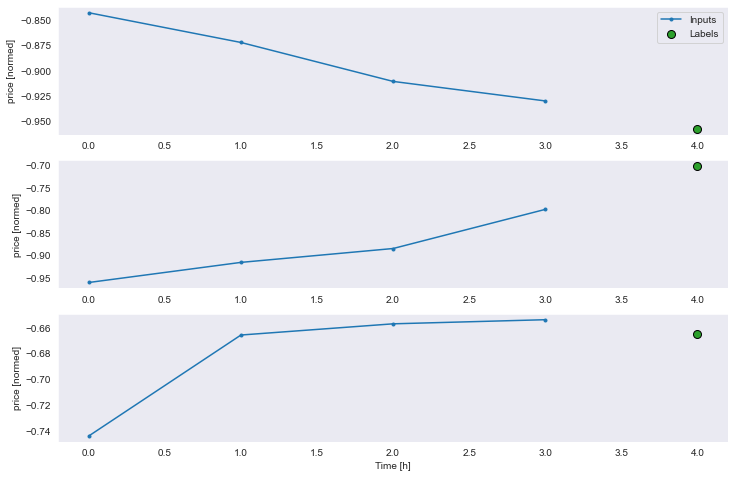

In [34]:
w2.plot()

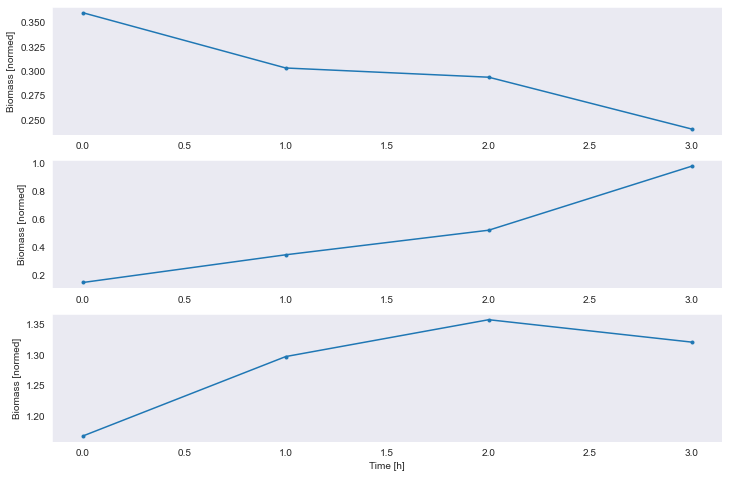

In [35]:
w2.plot(plot_col='Biomass')

In [37]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [38]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [39]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['price']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Input indices: [0 1 2 3]
Label indices: [4]
Label column name(s): ['price']> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


(TensorSpec(shape=(None, 4, 24), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [40]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 4, 24)
Labels shape (batch, time, features): (32, 1, 1)


# Single step models

In [41]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['price'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['price']

In [42]:
for example_inputs, example_labels in single_step_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 24)
Labels shape (batch, time, features): (32, 1, 1)


## Baseline

In [43]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [44]:
baseline = Baseline(label_index=column_indices['price'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
118/118 [==============================] - 1s 5ms/step - loss: 0.1867 - mean_absolute_error: 0.3054


In [45]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['price'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['price']

In [46]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 24)
Output shape: (32, 24, 1)


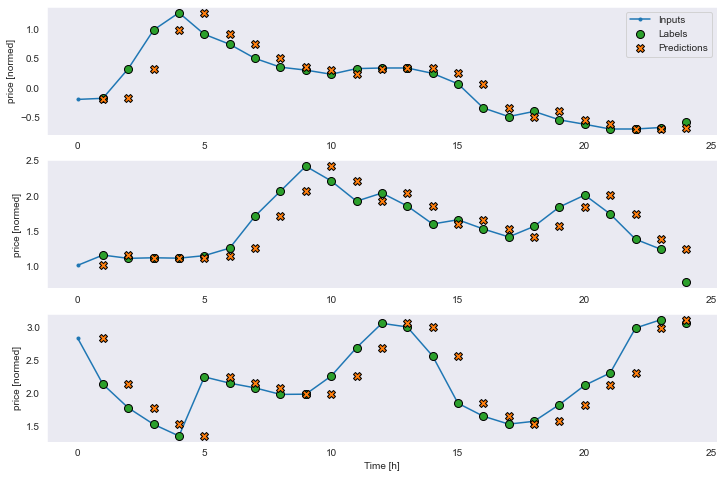

In [47]:
wide_window.plot(baseline)

## Linear model

In [48]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [49]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 24)
Output shape: (32, 1, 1)


In [50]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [51]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
413/413 [==============================] - 1s 2ms/step - loss: 0.8076 - mean_absolute_error: 0.6751 - val_loss: 0.9318 - val_mean_absolute_error: 0.7974
Epoch 2/20
413/413 [==============================] - 1s 1ms/step - loss: 0.2115 - mean_absolute_error: 0.3514 - val_loss: 0.4901 - val_mean_absolute_error: 0.5498
Epoch 3/20
413/413 [==============================] - 1s 1ms/step - loss: 0.1055 - mean_absolute_error: 0.2452 - val_loss: 0.3435 - val_mean_absolute_error: 0.4378
Epoch 4/20
413/413 [==============================] - 1s 1ms/step - loss: 0.0694 - mean_absolute_error: 0.1944 - val_loss: 0.2643 - val_mean_absolute_error: 0.3726
Epoch 5/20
413/413 [==============================] - 1s 1ms/step - loss: 0.0537 - mean_absolute_error: 0.1646 - val_loss: 0.2186 - val_mean_absolute_error: 0.3310
Epoch 6/20
413/413 [==============================] - 1s 1ms/step - loss: 0.0466 - mean_absolute_error: 0.1477 - val_loss: 0.1959 - val_mean_absolute_error: 0.3100
Epoch 7/20
413/4

In [52]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 24, 24)
Output shape: (32, 24, 1)


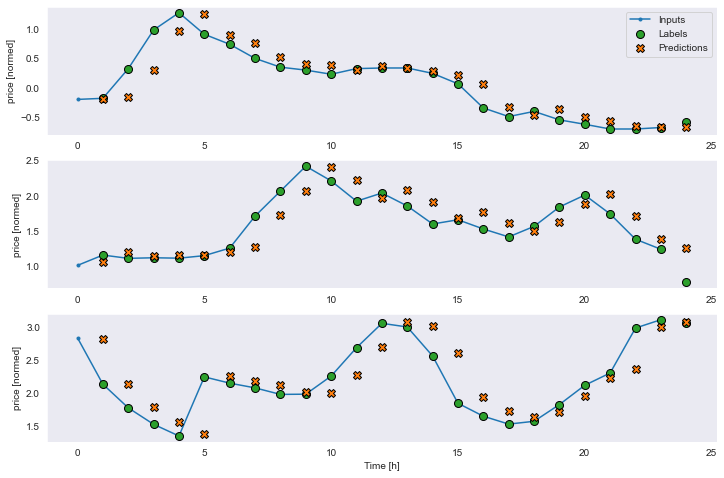

In [53]:
wide_window.plot(linear)

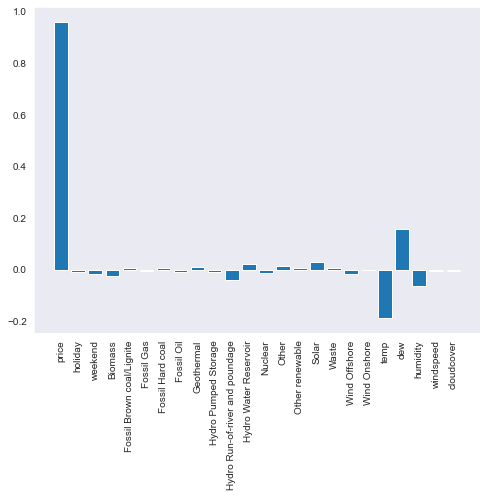

In [54]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

## Dense

In [55]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
413/413 [==============================] - 1s 2ms/step - loss: 0.1011 - mean_absolute_error: 0.2136 - val_loss: 0.4146 - val_mean_absolute_error: 0.4696
Epoch 2/20
413/413 [==============================] - 1s 1ms/step - loss: 0.0471 - mean_absolute_error: 0.1512 - val_loss: 0.3286 - val_mean_absolute_error: 0.4144
Epoch 3/20
413/413 [==============================] - 1s 2ms/step - loss: 0.0427 - mean_absolute_error: 0.1417 - val_loss: 0.2926 - val_mean_absolute_error: 0.3875
Epoch 4/20
413/413 [==============================] - 1s 1ms/step - loss: 0.0399 - mean_absolute_error: 0.1364 - val_loss: 0.2786 - val_mean_absolute_error: 0.3778
Epoch 5/20
413/413 [==============================] - 1s 2ms/step - loss: 0.0382 - mean_absolute_error: 0.1319 - val_loss: 0.2660 - val_mean_absolute_error: 0.3729
Epoch 6/20
413/413 [==============================] - 1s 2ms/step - loss: 0.0372 - mean_absolute_error: 0.1307 - val_loss: 0.2940 - val_mean_absolute_error: 0.3995
Epoch 7/20
118/1

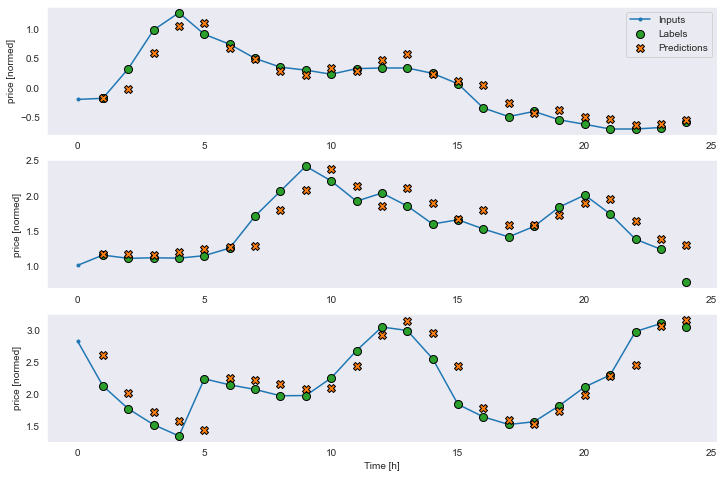

In [56]:
wide_window.plot(dense)

## Multi-step dense

In [57]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['price'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['price']

Text(0.5, 1.0, 'Given 3 hours of inputs, predict 1 hour into the future.')

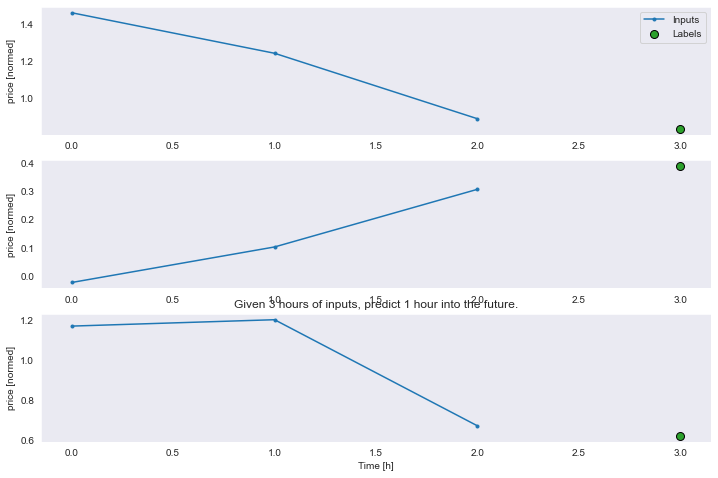

In [58]:
conv_window.plot()
plt.title("Given 3 hours of inputs, predict 1 hour into the future.")

In [59]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [60]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 24)
Output shape: (32, 1, 1)


In [62]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

118/118 [==============================] - 0s 924us/step - loss: 0.1956 - mean_absolute_error: 0.3263


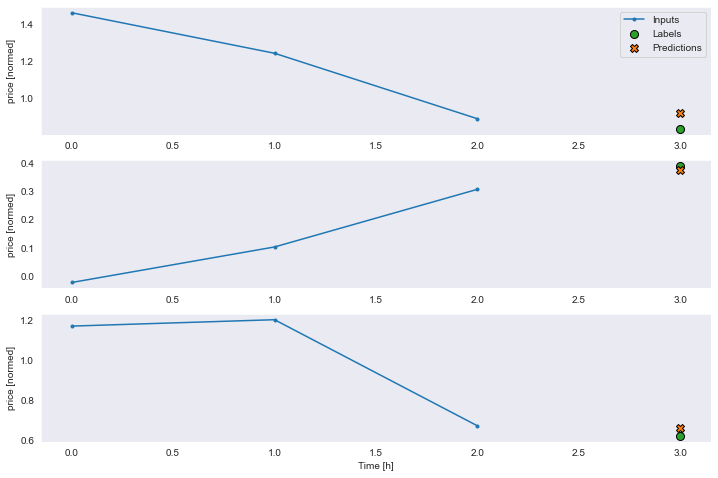

In [63]:
conv_window.plot(multi_step_dense)

In [64]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

Input shape: (32, 24, 24)

InvalidArgumentError:Matrix size-incompatible: In[0]: [32,576], In[1]: [72,32] [Op:MatMul]


## Convolution neural network

In [65]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [66]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 24)
Output shape: (32, 1, 1)


In [67]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

118/118 [==============================] - 0s 1ms/step - loss: 0.1877 - mean_absolute_error: 0.3194


In [68]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 24)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [70]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['price'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['price']

In [71]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 24)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


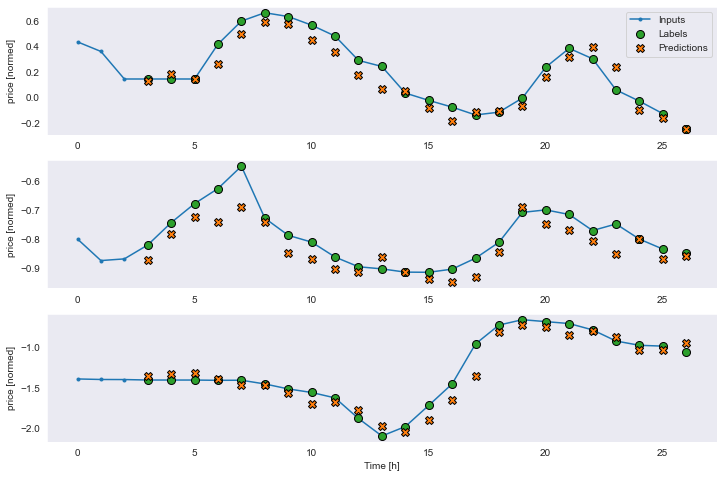

In [72]:
wide_conv_window.plot(conv_model)

## Recurrent neural network - best for time series forecasting

In [73]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [74]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 24)
Output shape: (32, 24, 1)


In [75]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

118/118 [==============================] - 0s 2ms/step - loss: 0.2381 - mean_absolute_error: 0.3366


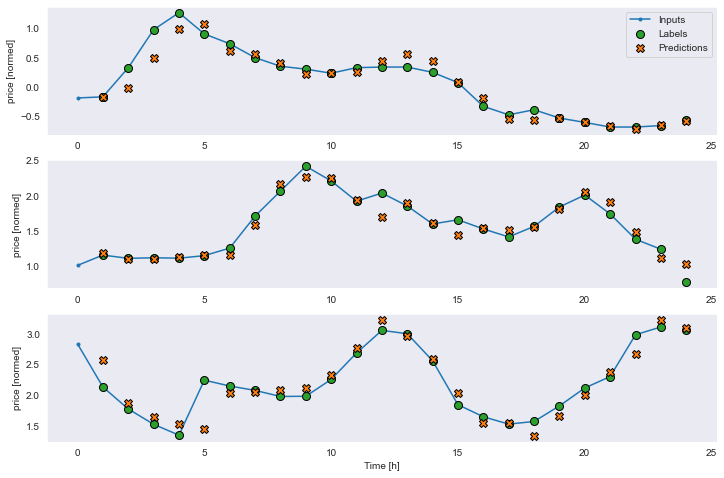

In [76]:
wide_window.plot(lstm_model)

## Performance

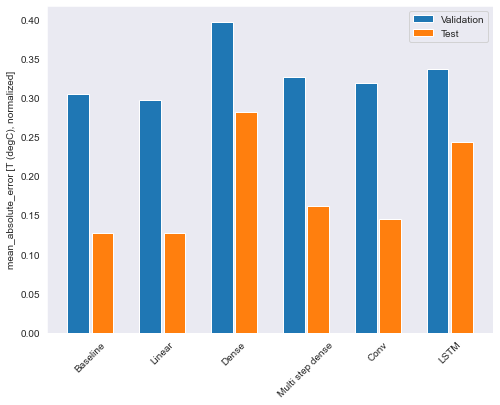

In [77]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [78]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 0.1273
Linear      : 0.1266
Dense       : 0.2814
Multi step dense: 0.1621
Conv        : 0.1448
LSTM        : 0.2435


# Multi-step models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

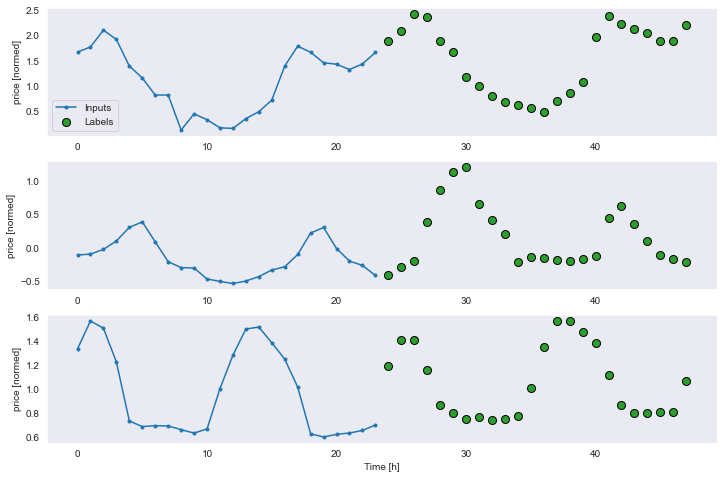

In [79]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

## Baselines

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
117/117 [==============================] - 1s 4ms/step - loss: 0.5936 - mean_absolute_error: 0.4369


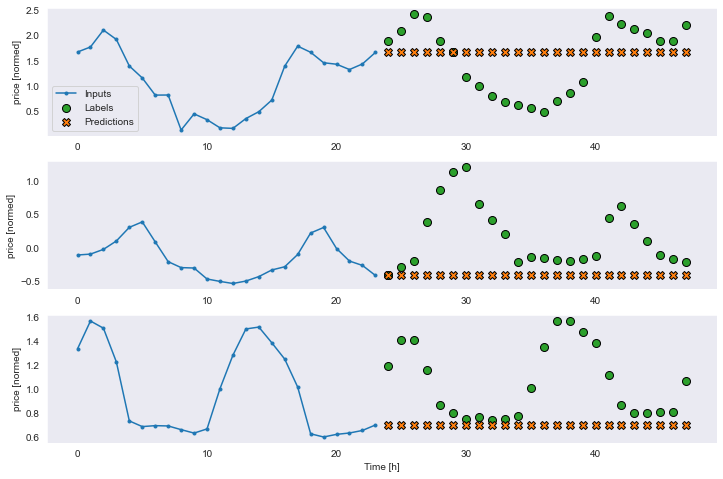

In [80]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)

117/117 [==============================] - 0s 4ms/step - loss: 0.4675 - mean_absolute_error: 0.4172


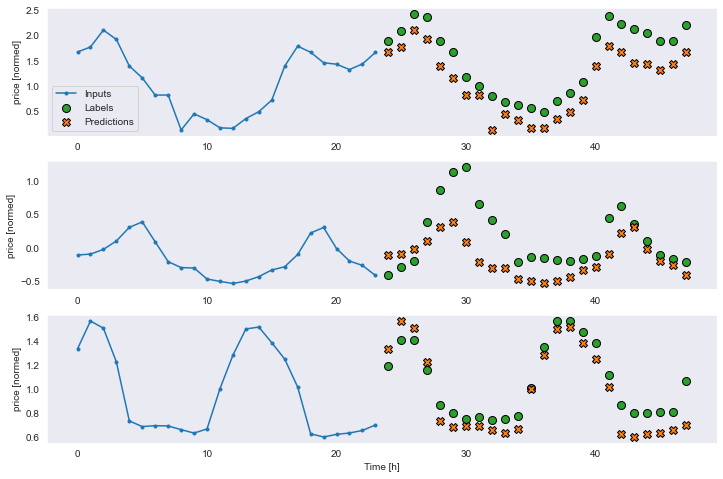

In [81]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## Single-shot models

### Linear

117/117 [==============================] - 0s 1ms/step - loss: 0.3784 - mean_absolute_error: 0.4033


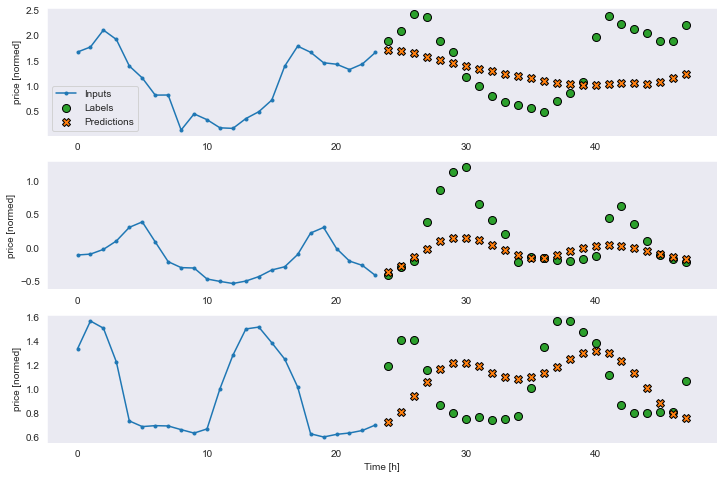

In [82]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

117/117 [==============================] - 0s 1ms/step - loss: 0.4086 - mean_absolute_error: 0.4385


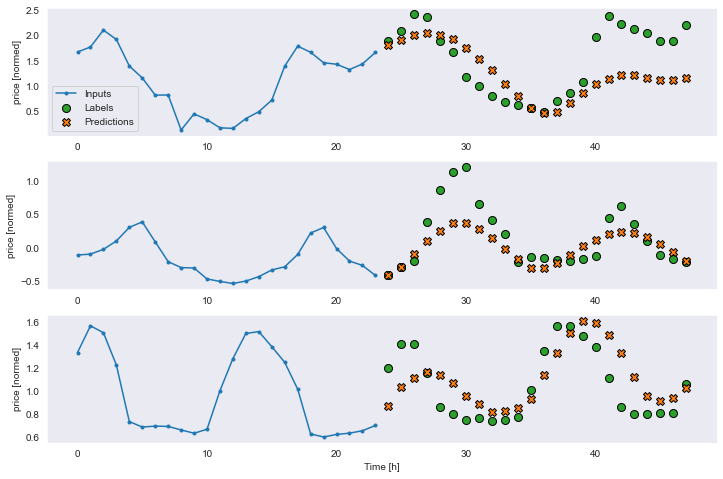

In [83]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### CNN

117/117 [==============================] - 0s 1ms/step - loss: 0.3801 - mean_absolute_error: 0.4325


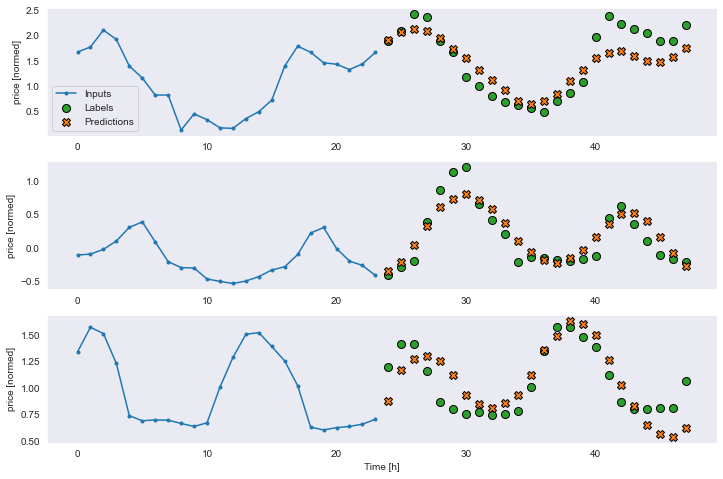

In [84]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### RNN

117/117 [==============================] - 0s 2ms/step - loss: 0.4643 - mean_absolute_error: 0.4895


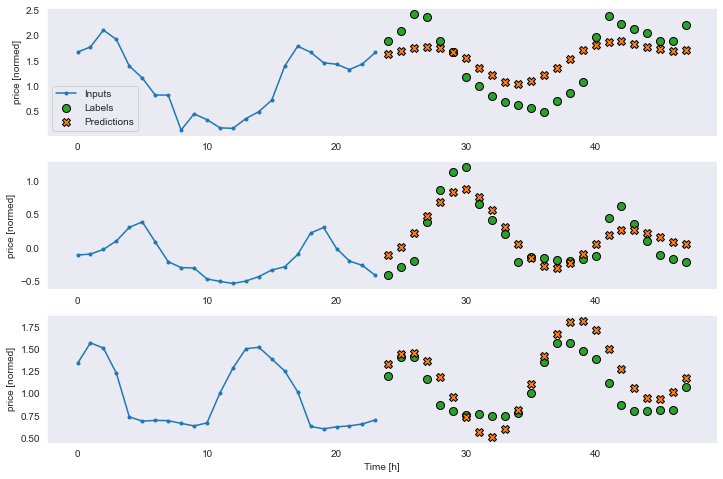

In [85]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### Autoregressive model

#### RNN

In [86]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [87]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [88]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [89]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 24])

In [90]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [91]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

Output shape (batch, time, features):  (32, 24, 24)


117/117 [==============================] - 0s 3ms/step - loss: 0.8433 - mean_absolute_error: 0.6823


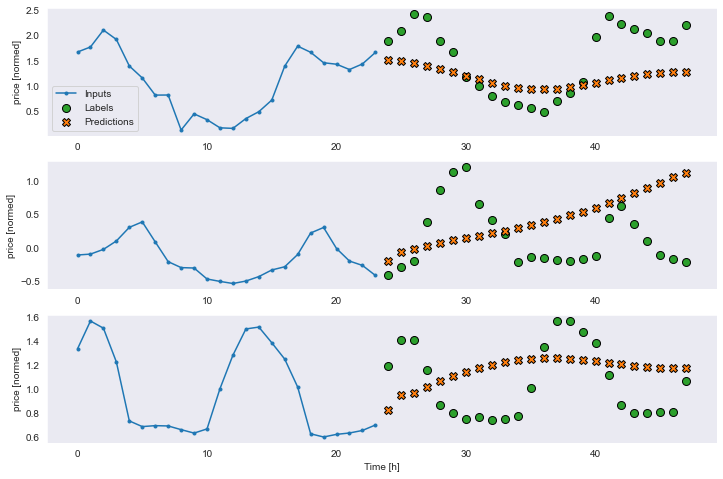

In [92]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### Performance

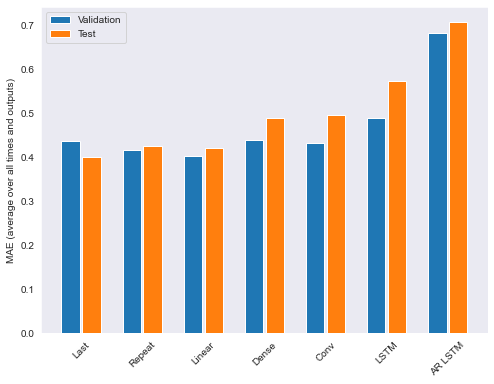

In [93]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

In [94]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.4004
Repeat  : 0.4253
Linear  : 0.4210
Dense   : 0.4897
Conv    : 0.4948
LSTM    : 0.5726
AR LSTM : 0.7067
